In [1]:
%%capture
%load_ext autoreload
%autoreload 2
#Basic Imports
import os,sys
os.chdir('/home/asebaq/MSMatch')

from tqdm import tqdm,trange
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay
import torch
import pandas as pd

from utilities.visualize import PredictionMasks
from datasets.ssl_dataset import SSL_Dataset
from datasets.data_utils import get_data_loader
from utils import get_model_checkpoints
from utils import net_builder
from utils import clean_results_df

In [2]:
from utilities.visualize import PredictionMasks

In [3]:
csv_folder = "/home/asebaq/MSMatch/cvs_folder" #Path where tmp csv files are stored
# folder="/home/asebaq/MSMatch/trained_models/rgb/RGB_50_32/eurosat_rgb/FixMatch_archefficientnet-b0_batch32_confidence0.95_lr0.03_uratio7_wd0.0005_wu1.0_seed0_numlabels50_optSGD"
# folder="/home/asebaq/MSMatch/trained_models/ms/4000/fixmatch/eurosat_ms/FixMatch_archefficientnet-b0_batch64_confidence0.95_lr0.03_uratio7_wd0.0005_wu1.0_seed0_numlabels4000_optSGD"
# folder="/home/asebaq/MSMatch/trained_models/ms/50/fixmatch/eurosat_ms/FixMatch_archefficientnet-b0_batch64_confidence0.95_lr0.03_uratio7_wd0.0005_wu1.0_seed0_numlabels50_optSGD"
folder="/home/asebaq/MSMatch/saved_models/fixmatch/landcoverai/FixMatch_archefficientnet-b0_batch8_confidence0.95_lr0.03_uratio7_wd0.0005_wu1.0_seed0_numlabels50_optSGD"
sort_criterion = "numlabels" # Accepted net, numlabels
seed_wanted = [0,1,2] # Seed wanted (the others will be filtered)

In [4]:
get_model_checkpoints(folder)

(['/home/asebaq/MSMatch/saved_models/fixmatch/landcoverai/FixMatch_archefficientnet-b0_batch8_confidence0.95_lr0.03_uratio7_wd0.0005_wu1.0_seed0_numlabels50_optSGD/model_best.pth'],
 [{'dataset': 'landcoverai',
   'net': 'efficientnet-b0',
   'batch': 8,
   'confidence': 0.95,
   'lr': 0.03,
   'uratio': 7,
   'wd': 0.0005,
   'wu': 1.0,
   'seed': 0,
   'numlabels': 50,
   'opt': 'SGD',
   'iterations': 50000}])

In [5]:
checkpoints, run_args = get_model_checkpoints(folder)
if os.name == 'nt':
       [print(_.split("\\")[1]) for _ in checkpoints];
else:
       [print(_.split("/")[1]) for _ in checkpoints];

home


In [6]:
checkpoint = checkpoints[0]
args = run_args[0]

In [7]:
args["batch_size"] = 4
args["data_dir"] = "/home/asebaq/MSMatch/data/"
args["use_train_model"] = False
args["load_path"] = checkpoint
args["segmentation"] = True

checkpoint_path = args["load_path"]

model_checkpoint = torch.load(checkpoint_path,map_location='cuda:0')
# model_checkpoint = torch.nn.DataParallel(model)
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in model_checkpoint.items():
    name = k.replace("module.", "") # remove `module.`
    new_state_dict[name] = v



load_model = (model_checkpoint["train_model"] if args["use_train_model"] else model_checkpoint["eval_model"])
_net_builder = net_builder(args["net"],False,{}, segmentation=True)
_eval_dset = SSL_Dataset(name=args["dataset"], train=False, data_dir=args["data_dir"], seed=args["seed"])
eval_dset = _eval_dset.get_dset()
net = _net_builder(num_classes=_eval_dset.num_classes, in_channels=_eval_dset.num_channels)
net.load_state_dict(new_state_dict, strict=False)

if torch.cuda.is_available():
    net.cuda()
net.eval()

eval_loader = get_data_loader(eval_dset, args["batch_size"], num_workers=1)
# label_encoding = _eval_dset.label_encoding
inv_transf = _eval_dset.inv_transform

Using not pretrained model efficientnet-b0 ...


100%|███████████████████████████████████████████████████████████| 1602/1602 [00:39<00:00, 40.92it/s]


In [9]:
images, masks = next(iter(eval_loader))

In [10]:
print(images.shape, masks.shape)

torch.Size([4, 3, 128, 128]) torch.Size([4, 128, 128])


In [11]:
images = images.type(torch.FloatTensor).cuda()
preds = net(images)

In [12]:
values, indices = torch.max(preds, axis = 1)

In [13]:
PredictionMasks

utilities.visualize.PredictionMasks

In [19]:
model_predictor = PredictionMasks(net, eval_loader, inv_transf, 5)

2023-02-01 03:34:17.485373: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-01 03:34:18.083705: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/asebaq/miniconda3/envs/msmatch1/lib/python3.9/site-packages/cv2/../../lib64:
2023-02-01 03:34:18.083759: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/asebaq/miniconda3/envs/msmatch1/lib/pytho

In [15]:
print(sys.setrecursionlimit(6000))


None


In [16]:
# import resource
# resource.setrlimit(resource.RLIMIT_STACK, [0x10000000, resource.RLIM_INFINITY])
# sys.setrecursionlimit(0x100000)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(array([0, 2, 3, 4]), array([  828, 15550,     4,     2]))
(128, 128, 3) (128, 128, 3) (128, 128, 3)


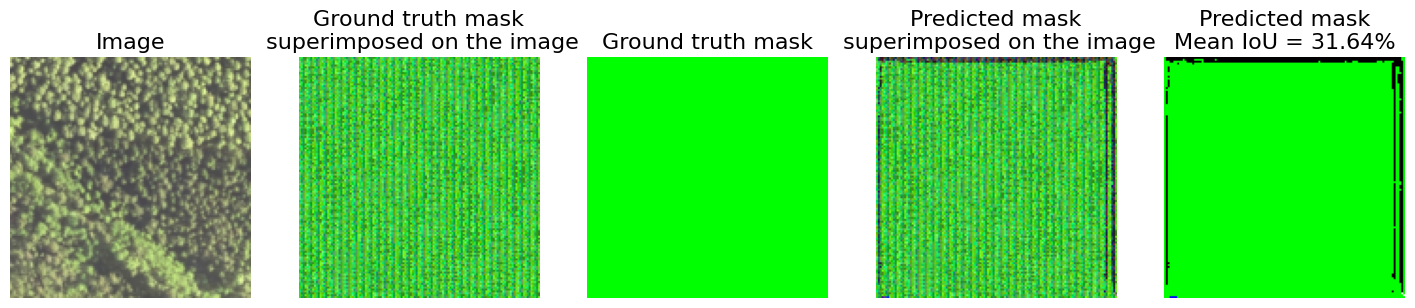

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(array([0, 2, 3, 4]), array([  826, 15552,     4,     2]))
(128, 128, 3) (128, 128, 3) (128, 128, 3)


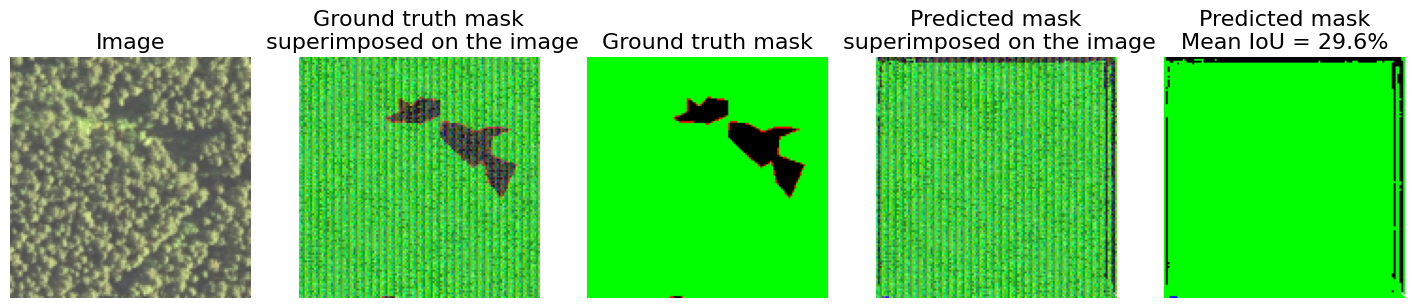

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(array([0, 2, 3, 4]), array([  830, 15548,     4,     2]))
(128, 128, 3) (128, 128, 3) (128, 128, 3)


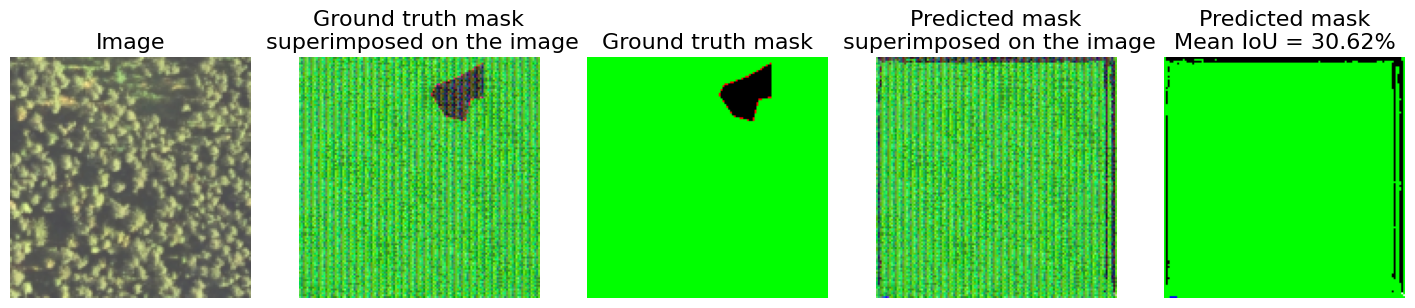

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(array([0, 2, 3, 4]), array([  827, 15551,     4,     2]))
(128, 128, 3) (128, 128, 3) (128, 128, 3)


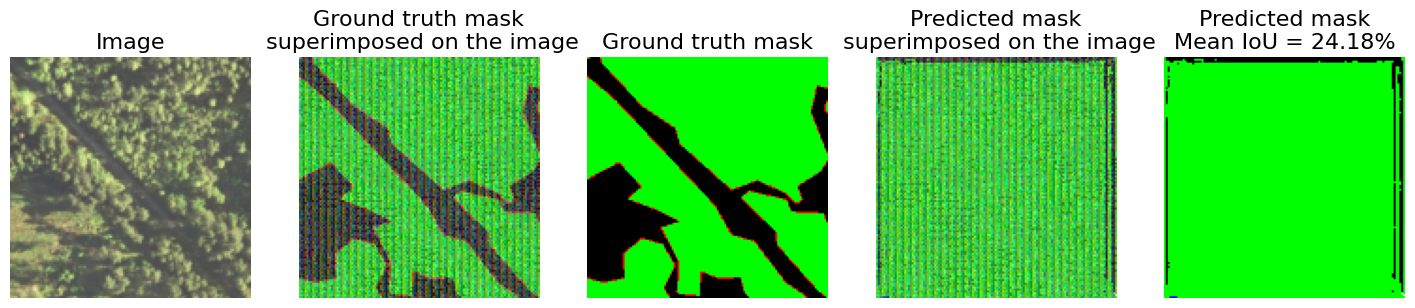

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(array([0, 2, 3, 4]), array([  827, 15551,     4,     2]))
(128, 128, 3) (128, 128, 3) (128, 128, 3)


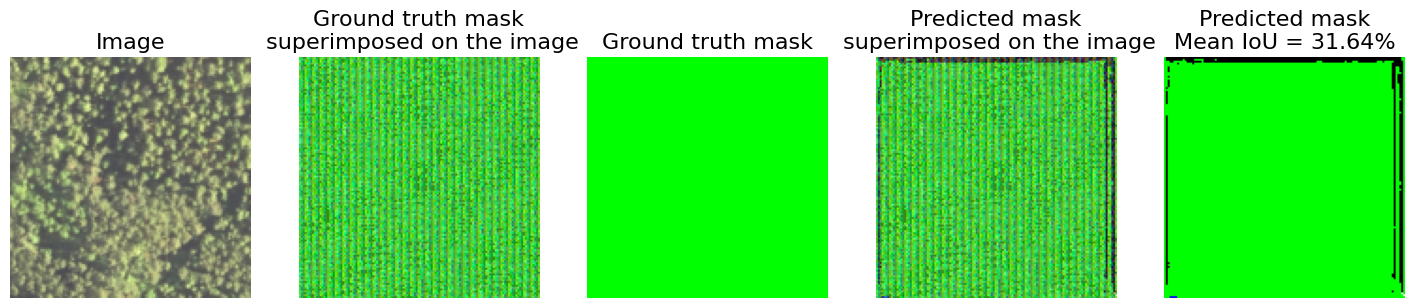

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(array([0, 2, 3, 4]), array([  829, 15549,     4,     2]))
(128, 128, 3) (128, 128, 3) (128, 128, 3)


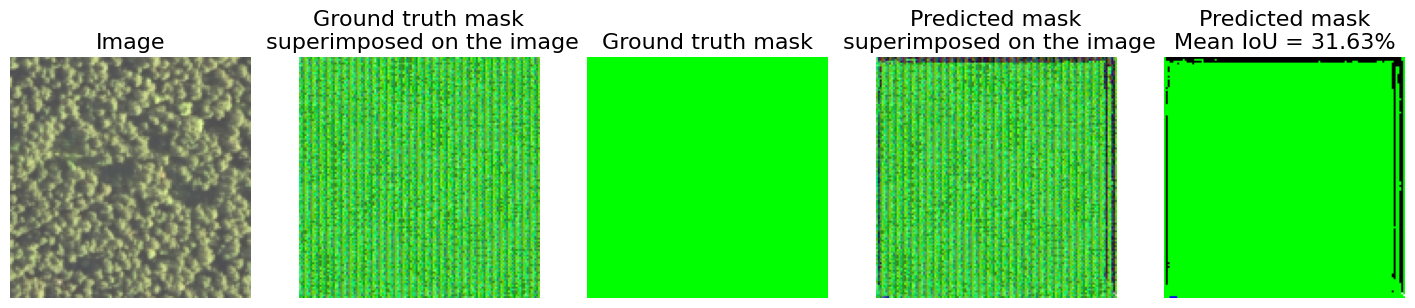

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(array([0, 2, 3, 4]), array([  827, 15551,     4,     2]))
(128, 128, 3) (128, 128, 3) (128, 128, 3)


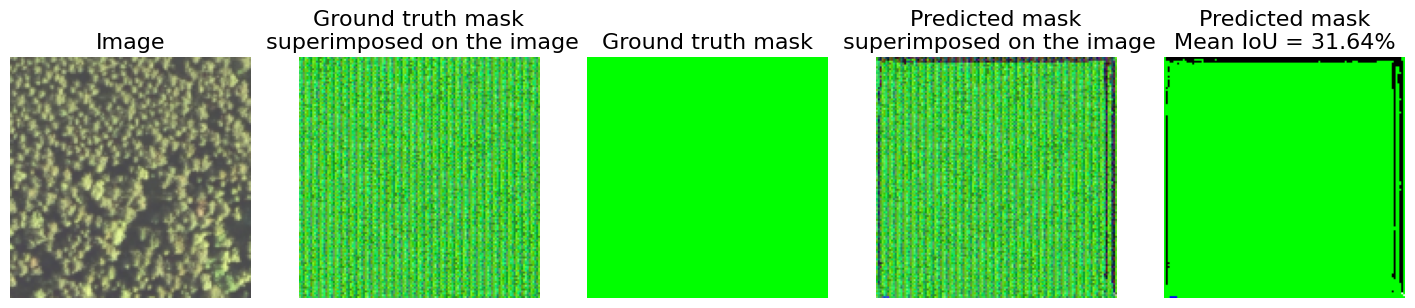

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(array([0, 2, 3, 4]), array([  830, 15548,     4,     2]))
(128, 128, 3) (128, 128, 3) (128, 128, 3)


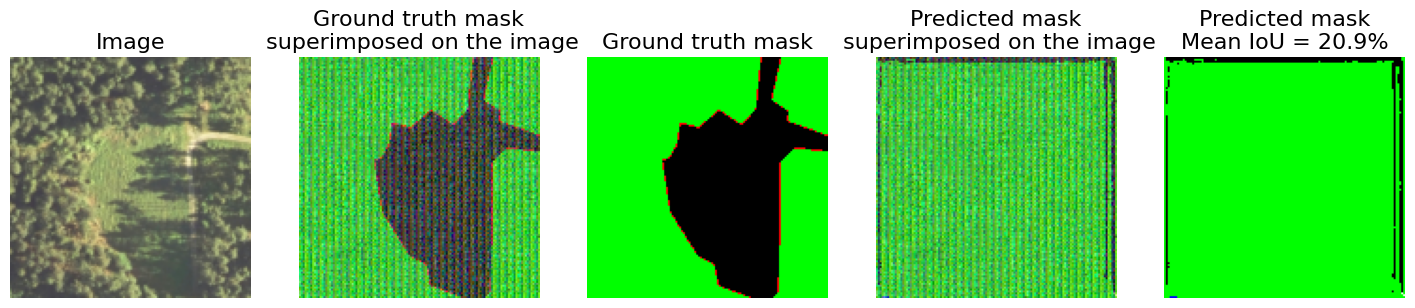

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(array([0, 2, 3, 4]), array([  827, 15551,     4,     2]))
(128, 128, 3) (128, 128, 3) (128, 128, 3)


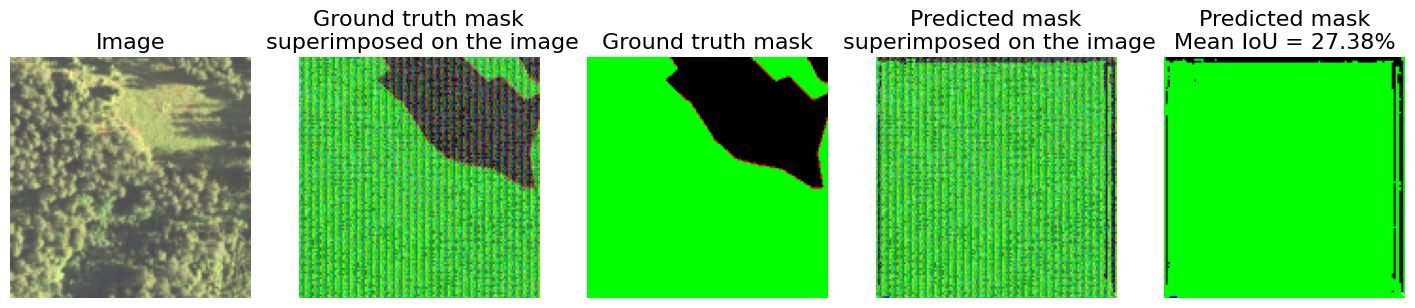

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(array([0, 2, 3, 4]), array([  828, 15550,     4,     2]))
(128, 128, 3) (128, 128, 3) (128, 128, 3)


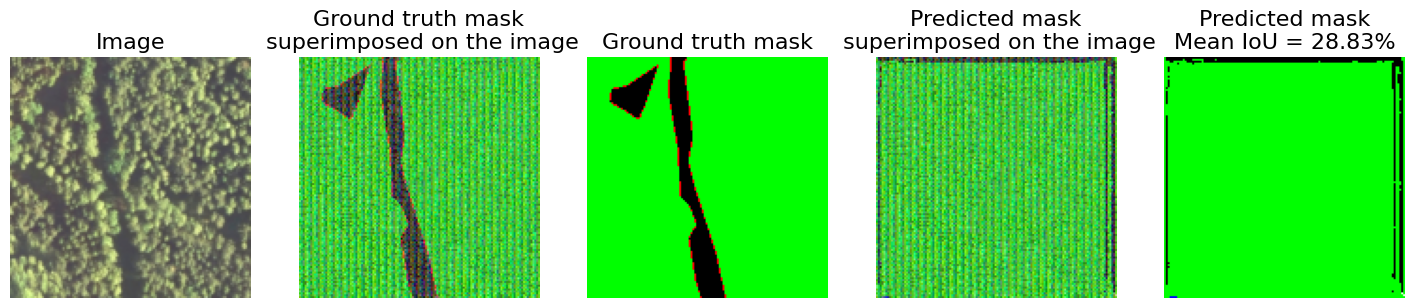

(array([0, 2, 3, 4]), array([  827, 15551,     4,     2]))


In [24]:
model_predictor.display_overlay_predictions_for_test_set(
    how_many_images=10,
    figure_size = (18, 4),
    randomly=True,
    export_to_file=True
)